![LendingClub](https://www.personalincome.org/wp-content/uploads/2015/09/lending-club-logo.png)

In [ ]:
# The Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./input"))

# Any results you write to the current directory are saved as output.

![How Lending Club Works](https://digital.hbs.edu/platform-digit/wp-content/uploads/sites/2/2018/03/Showing-how-the-lending-club-works-and-makes-money-1.png)
The loan_untouched data is the dataset that we can download from Kaggle Lending Club Data. These files contain complete loan data for all loans issued through the 2007-2015, including the current loan status (Current, Late, Fully Paid, etc.) and latest payment information. The file containing loan data through the "present" contains complete loan data for all loans issued through the previous completed calendar quarter. Additional features include credit scores, number of finance inquiries, address including zip codes, and state, and collections among others. The file is a matrix of about 890 thousand observations and 75 variables. 

https://www.kaggle.com/wendykan/lending-club-loan-data

In [ ]:
##Reading the dataset
df = pd.read_csv("./input/loan_untouched.csv", low_memory=False)
df.head(3)

Note that it has consumed about 10Gb of memory, 11.8GB specifically. This is a sign that we need to be very careful about memory mangagement, especially in a low-resource setting.

Let us check some basics about the dataset. First about its size and then about its dimensions. 

In [ ]:
df.shape 

In [ ]:
df.columns

What does the various columns mean? We can rely on the dictionary provided by the Lending Street. We use Pandas to read the xlsx file, along with display style formatting

In [ ]:
df_description = pd.read_excel('./input/LCDataDictionary.xlsx').dropna()
df_description.style.set_properties(subset=['Description'], **{'width': '1000px'})

## Exploratory Data Analytics

We start out with the metric of the game: loan status

In [ ]:
df["loan_status"].value_counts()

In [ ]:
df["loan_status"].value_counts().plot(kind='bar');


We see that there are only 31 default cases. In the light that harges off means that the consumer has defaulted for long enough time such that the creditors has 'given up' in getting the money back, we include them in our default cases. 

In [ ]:
target_list = [1 if i=='Default' or i=='Charged Off' else 0 for i in df['loan_status']]

df['TARGET'] = target_list
df['TARGET'].value_counts()

Even after including the charges off cases, we have a class imbalance issue: the 'positive' cases of defaults are much less frequent than the 'negative' non-default cases. Later in training, we need to be careful about this. 

In [ ]:
# loan_status cross
loan_status_cross = pd.crosstab(df['addr_state'], df['loan_status']).apply(lambda x: x/x.sum() * 100)
number_of_loanstatus = pd.crosstab(df['addr_state'], df['loan_status'])


# Round our values
loan_status_cross['Charged Off'] = loan_status_cross['Charged Off'].apply(lambda x: round(x, 2))
loan_status_cross['Default'] = loan_status_cross['Default'].apply(lambda x: round(x, 2))
loan_status_cross['Does not meet the credit policy. Status:Charged Off'] = loan_status_cross['Does not meet the credit policy. Status:Charged Off'].apply(lambda x: round(x, 2))
loan_status_cross['In Grace Period'] = loan_status_cross['In Grace Period'].apply(lambda x: round(x, 2))
loan_status_cross['Late (16-30 days)'] = loan_status_cross['Late (16-30 days)'].apply(lambda x: round(x, 2))
loan_status_cross['Late (31-120 days)'] = loan_status_cross['Late (31-120 days)'].apply(lambda x: round(x, 2))


number_of_loanstatus['Total'] = number_of_loanstatus.sum(axis=1) 
# number_of_badloans
number_of_loanstatus

Actually, after we set the target column, we can drop the loan_status column, as a role of thumb

In [ ]:
df.drop('loan_status',axis=1,inplace=True)

In [ ]:
df.info()


# Exploratory Data Visualization

In [ ]:
from plotly import tools
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(y=df.term.value_counts(), x=df.term.value_counts().index)
plt.xticks(rotation=0)
plt.title("Loan's Term Distribution")
plt.ylabel("Count")

In [ ]:
plt.figure(figsize=(18, 5))
sns.barplot(y=df.grade.value_counts(), x=df.grade.value_counts().index)
plt.xticks(rotation=0)
plt.title("Grade Distribution")
plt.ylabel("Count")

In [ ]:
plt.figure(figsize=(18, 10))
sns.barplot(y=df.sub_grade.value_counts(), x=df.sub_grade.value_counts().index)
plt.xticks(rotation=0)
plt.title("Subgrade Distribution")
plt.ylabel("Count")

In [ ]:
plt.figure(figsize=(18, 10))
sns.barplot(y=df.purpose.value_counts(), x=df.purpose.value_counts().index)
plt.xticks(rotation=0)
plt.title("Purpose Distribution")
plt.ylabel("Count")
plt.xticks(rotation=30)

In [ ]:
plt.figure(figsize=(18, 10))
sns.barplot(y=df.emp_title.value_counts()[:15], x=df.emp_title.value_counts()[:15].index)
plt.xticks(rotation=0)
plt.title("Top 15 most popular employment title")
plt.ylabel("Count")
plt.xticks(rotation=30)

In [ ]:
plt.figure(figsize = (14,6))

sns.barplot(x='grade', y='loan_amnt', 
              data=df)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_xlabel("Duration Distribuition", fontsize=15)
g.set_ylabel("Mean amount", fontsize=15)
g.set_title("Loan Amount by Grades", fontsize=20)
plt.legend(loc=1)
plt.show()

## Missing Value Analysis

### Part 1, Dataset-wide analysis

In [ ]:
def null_values(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [ ]:
missing_values = null_values(df)

In [ ]:
missing_values

More specifically, we can look at the missing values for float64 type of columns, sorted by the percentage of missing

In [ ]:
df.select_dtypes(include=['float64']).describe()\
.T.assign(missing = df.apply(lambda x : (1 - x.count() /len(x)))).sort_values(by = 'missing',ascending = False)


We can also look at the missing values for object type of columns, sorted by the percentage of missing

In [ ]:
df.select_dtypes(include=['O']).describe()\
.T.assign(missing = df.apply(lambda x : (1 - x.count() /len(x)))).sort_values(by = 'missing',ascending = False)

We decides to drop the columns where 25% or more values is missing 

In [ ]:
df.dropna(
    axis=1, thresh=int(0.75 * len(df)),
    inplace=True)

We can take a look at the new dataframe

In [ ]:
df.describe().T.assign(
    missing_pct=df.apply(
        lambda x: (1 - x.count() / len(x)))).sort_values(
            by='missing_pct', ascending=False)

### Part 2, finding columns with missing value that needs to be filled with mean instead of zero

Here we look at each columns in the above, we can just take a look at the top columns and analyze the financial context of each column. 

The basic logic below is that we assume a 'good' population that follow a summary statistics that makes sense simply by common sense, like positive annual income (instead of 0 income)

mths_since_recent_inq: should be filled with mean


num_tl_120dpd_2m: Number of accounts currently 120 days past due: should be filled with mean


mo_sin_old_il_acct:Months since oldest bank installment account opened. Should be filled with mean

bc_util: Ratio of total current balance to high credit/credit limit for all bankcard accounts: Should be filled with mean

percent_bc_gt_75: Percentage of all bankcard accounts > 75% of limit: should be filled with zero 

bc_open_to_buy: Total open to buy on revolving bankcards. Should be filled with zero

mths_since_recent_bc: Months since most recent bankcard account opened: Should be filled with zero 

pct_tl_nvr_dlq: Percent of trades never delinquent: should be filled with zero 

avg_cur_bal: Average current balance of all accounts: should be filled with zero 

mo_sin_rcnt_rev_tl_op: Months since most recent revolving account opened: should be filled with zero 

mo_sin_old_rev_tl_op: Months since most recent revolving account opened: should be filled with mean

num_rev_accts:Number of revolving accounts: should be filled with zero 

tot_cur_bal: Total current balance of all accounts: should be filled with zero 

num_il_tl:  Number of installment accounts: should be filled with zero 

tot_coll_amt: Total collection amounts ever owed: Should be filled with zero 

num_accts_ever_120_pd:Number of accounts ever 120 or more days past due: Should be filled with zero





In [ ]:
cols_fill_with_mean = ['mths_since_recent_inq',
                       'num_tl_120dpd_2m',
                       'mo_sin_old_il_acct',
                       'bc_util',
                       'mo_sin_old_rev_tl_op',
                       'revol_util', 'open_acc', 'total_acc', 
                       'annual_inc']


In [ ]:
for col in cols_fill_with_mean:
    mean_of_col = df[col].mean()
    df[col] = df[col].fillna(mean_of_col)

### Dropping columns that does not contribute to analysis

In [ ]:
df['emp_title']

In [ ]:
df['emp_title'].value_counts()

In [ ]:
df['title']

In [ ]:
df['title'].value_counts()

In [ ]:
df['zip_code']

For emp_title and title, we notice that there are too many entries that appears only once. If we were to do one-hot encoding, they would add unnecessary complexity to our parameter space. We do recognize that if we have more time, we should convert low-frequency title and emp-titles into one category while keeping high-frequency titles. For zip_code, since the last two digits are missing, it also will add necessary complexity in parameter space while not contributing to analysis. 

In [ ]:
df.drop(['emp_title','title','zip_code'],axis=1,inplace=True)

In [ ]:
df.shape

### Part 3, column(feature)-specific missing value analysis and cleaning for object columns

As the last step we take a look at the columns with missing values after basic cleaning and dropping. We need to specifiy object columns and number columns

In [ ]:
df.select_dtypes(include=['O']).describe()\
.T.assign(missing = df.apply(lambda x : (1 - x.count() /len(x)))).sort_values(by = 'missing',ascending = False)

Note that only the first four columns have value missing. 

Since there are only a few columns

In [ ]:
df['emp_length']

Let us fill in the null values with 0 assuming the applicant does not work and consequently does not report their employment length. And then we convert the format of the column from object to 

In [ ]:
df['emp_length'].fillna(value=0,inplace=True)

df['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)

df['emp_length'].value_counts().sort_values().plot(kind='barh',figsize=(18,8))
plt.title('Number of loans distributed by Employment Years',fontsize=20)
plt.xlabel('Number of loans',fontsize=15)
plt.ylabel('Years worked',fontsize=15);

Also, there are four month/date object that we can simply use pandas built-in toolbox to convert to datetime object. Instead of filling the null values with zero values, we can fill with the most frequenct value. 

In [ ]:
df['last_pymnt_d'].value_counts().sort_values().tail()

We know we want to fill the missing value with Feb-2019 as the most frequent date for last_pymnt_d

In [ ]:
df['last_pymnt_d']= pd.to_datetime(df['last_pymnt_d'].fillna('2016-09-01'))


In [ ]:
df['last_credit_pull_d'].value_counts().sort_values().tail()

We know we want to fill the missing value with Feb-2019 as the most frequent date for last_credit_pull_d

In [ ]:
df['last_credit_pull_d']= pd.to_datetime(df['last_credit_pull_d'].fillna("2016-09-01"))


In [ ]:
df['earliest_cr_line'].value_counts().sort_values().tail()

We know we want to fill the missing value with Sep-2004 as the most frequent date for earliest_cr_line

In [ ]:
df['earliest_cr_line']= pd.to_datetime(df['earliest_cr_line'].fillna('2004-09-01'))


Now we shall use label encoding to encode the object columns with two unique values or less

We know we want to fill the missing value with Mar 2016 as the most frequent date for issue_d

In [ ]:
df['issue_d'].value_counts().sort_values().tail()

In [ ]:
df['issue_d']= pd.to_datetime(df['issue_d'].fillna("2016-03-01"))




## Save the dataframe at 09:30pm, Sunday

In [ ]:
df.to_pickle('Before_datetime')

## Datetime Feature Enginnering 

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns

In [ ]:
df = pd.read_pickle('Before_datetime')

In [ ]:
df.select_dtypes(exclude=[np.number,object]).head()

Two metric we can feature enginnering is: 

1. The months between issue date and last payment date, which is how long the loan has been around
2. The months between earliest credit line and the last credit pull date, which is similar to the length of credit history

In [ ]:
df['months_of_loan']= (df['last_pymnt_d']-df['issue_d'])/np.timedelta64(1,'M')

In [ ]:
df['months_of_loan']=df['months_of_loan'].astype(int)

In [ ]:
df['months_of_credit_hisotory']= (df['last_credit_pull_d']-df['earliest_cr_line'])/np.timedelta64(1,'M')

In [ ]:
df['months_of_credit_hisotory']=df['months_of_credit_hisotory'].astype(int)

## Feature Cleaning up  

In [ ]:
df.info()

In [ ]:
df.select_dtypes(object).head()

We see that the term of the loan is still in string/object format, let us convert that into int

In [ ]:
df['term'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df['term']=df['term'].astype(int)

Check if 'term' is properly converted

In [ ]:
df['term'].head()

We remember that we converted emp_length. Check if it is in int format, if not, convert it to int

In [ ]:
df['emp_length'].head()

In [ ]:
df['emp_length']= df['emp_length'].astype(int)

In [ ]:
df.select_dtypes(object).columns

In [ ]:
df.to_pickle('ReadyforModelling')

# Note that ideally, we would like to model three metrics

1. **Loan Status** (We converted it into 'target' column), the lending club's final decision. However
We do recognize that Lending Club's business case is unique in terms of P2P lending. We should also 
model other parameters. 
2. **'Grade'**. This is Lending Club's secret sauce of assigning a grade to a borrower. More universal and thus more interesting to model. 
3. **'Subgrade'**. 'Grade' metric is added by another single digit number to further distingusih between different customers

When we model loan status, it is considered common to include 'Grade' and 'Subgrade'.
But when we model 'Grade' and 'Subgrade', it is debetable to include Loan Status or not
However, we know for certain that 'Subgrade' should not be a metric for 'Grade' modelling
And reversely, 'Grade' should not be a metric for 'Subgrade' 

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
df = pd.read_csv("./input/cleaned_up_loan.csv")

# 1. Loan Status Modelling


Label encoding the binary objects

In [ ]:
from sklearn import preprocessing
count = 0

for col in df:
    if df[col].dtype == 'object':
        if len(list(df[col].unique())) <= 2:     
            le = preprocessing.LabelEncoder()
            df[col] = le.fit_transform(df[col])
            count += 1
            print (col)
            
print('%d columns were label encoded.' % count)

Now we can use get_dummies to one hot encode all the rest categorical columns. We just need to convert the datetime objects back to strings

In [ ]:
df['last_pymnt_d'] = df['last_pymnt_d'].dt.strftime('%Y-%m')
df['issue_d'] =df['issue_d'].dt.strftime('%Y-%m')
df['last_credit_pull_d']=df['last_credit_pull_d'].dt.strftime('%Y-%m')
df['earliest_cr_line']=df['earliest_cr_line'].dt.strftime('%Y-%m')

In [ ]:
df = pd.get_dummies(df)

And we can drop the remaining null values now

In [ ]:
df.dropna(inplace=True)

## 1. Bagging

In [5]:
df = pd.read_csv("./input/cleaned_up_loan.csv")

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
import gc

In [6]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        
    elif train==False:
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))    
        

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('TARGET',axis=1),df['TARGET'],test_size=0.15,random_state=101)

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test=sc.transform(X_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


## 
We can create a baseline for accuracty and recall using logistics regression

In [11]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C = 0.0001,random_state=21)

log_reg.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=21,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [12]:
print_score(log_reg, X_train, y_train, X_test, y_test, train=False)

Test Result:

accuracy score: 0.9786

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    287182
           1       1.00      0.82      0.90     37342

   micro avg       0.98      0.98      0.98    324524
   macro avg       0.99      0.91      0.94    324524
weighted avg       0.98      0.98      0.98    324524


Confusion Matrix: 
 [[287048    134]
 [  6825  30517]]



### Note that for our business case, we would like to reduce the top right number in the confusion matrix which is false postive: we think that the applicant is a good loan borrower but he/she is not. Compared to the bottom left number, which is false negative, we as a business does not loss when we reject a good applicant, at least not as much as giving loan to a bad loaner. 

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
clf_rf = RandomForestClassifier(n_estimators=40, random_state=21)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
            oob_score=False, random_state=21, verbose=0, warm_start=False)

In [15]:
print_score(clf_rf, X_train, y_train, X_test, y_test, train=False)

Test Result:

accuracy score: 0.9968

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    287182
           1       1.00      0.97      0.99     37342

   micro avg       1.00      1.00      1.00    324524
   macro avg       1.00      0.99      0.99    324524
weighted avg       1.00      1.00      1.00    324524


Confusion Matrix: 
 [[287182      0]
 [  1052  36290]]



## 2) Boosting:

* Train weak classifiers 
* Add them to a final strong classifier by weighting. Weighting by accuracy (typically)
* Once added, the data are reweighted
  * Misclassified samples gain weight 
  * Algo is forced to learn more from misclassified samples   

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
from lightgbm import LGBMClassifier
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import gc
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
df = pd.read_csv("./input/cleaned_up_loan.csv")

In [ ]:
def kfold_lightgbm(train_df, num_folds, stratified = False):
    print("Starting LightGBM. Train shape: {}".format(train_df.shape))
    
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=47)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)

    oof_preds = np.zeros(train_df.shape[0])

    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET']]
    
    # Splitting the training set into folds for Cross Validation
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=12,#previous number 4
            n_estimators=1000, # Previous number 10000
            learning_rate=0.02,
            num_leaves=32,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.04,
            reg_lambda=0.073,
            min_split_gain=0.0222415,
            min_child_weight=40,
            silent=-1,
            verbose=-1
            #device= 'gpu',gpu_platform_id= 0,gpu_device_id= 0
            )

        # Fitting the model and evaluating by AUC
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 1000, early_stopping_rounds= 200)
        print_score(clf, train_x, train_y, valid_x, valid_y, train=False)
        # Dataframe holding the different features and their importance
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        # Freeing up memory
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    display_importances(feature_importance_df)
    return feature_importance_df

In [ ]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        
    elif train==False:
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))  

In [ ]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(15, 12))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

Starting LightGBM. Train shape: (2163488, 343)
Training until validation scores don't improve for 200 rounds.
[1000]	training's binary_logloss: 0.00154127	training's auc: 0.999953	valid_1's binary_logloss: 0.00183299	valid_1's auc: 0.999887
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00154127	training's auc: 0.999953	valid_1's binary_logloss: 0.00183299	valid_1's auc: 0.999887
Test Result:

accuracy score: 0.9996

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    383090
           1       1.00      1.00      1.00     49608

   micro avg       1.00      1.00      1.00    432698
   macro avg       1.00      1.00      1.00    432698
weighted avg       1.00      1.00      1.00    432698


Confusion Matrix: 
 [[383090      0]
 [   168  49440]]

Training until validation scores don't improve for 200 rounds.
[1000]	training's binary_logloss: 0.00153117	training's auc: 0.999951	

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


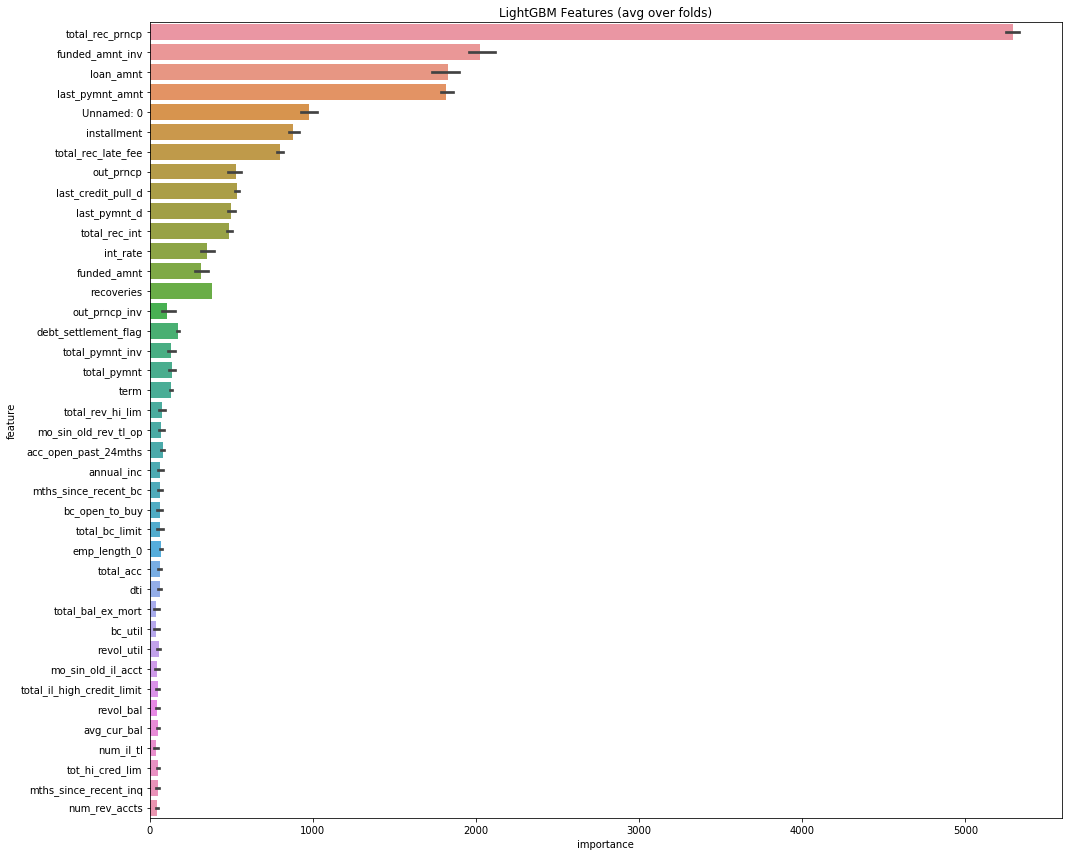

In [6]:
feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False)

#### We are relative excited by the 0 false positve value in the confusion matrix. This means that we did not borrow money to anyone who was going to default

Admittedly, due to time constraints (time conflicts with other job commitments) I was unable to produce complete analysis of Grade and Subgrade. 
The following is the fastai/pytorch code. It shall be run in a new envionment with Fastai installed with GPU/CUDA support


In [ ]:
from fastai.tabular import * # Fast AI tabular package


In [ ]:
pd.read_csv("./input/loan_untouched.csv", low_memory=False)

In [ ]:
procs = [FillMissing, Normalize]


To split our data into training and validation sets, we use valid indexes



In [ ]:
valid_idx = range(len(df)-2000, len(df))


Let us use the helper function that returns column names of cont and cat variables from given df.



Now we're ready to pass this information to TabularDataBunch.from_df to create the DataBunch that we'll use for training. Once we have our data ready in a DataBunch, we just need to create a model to then define a Learner and start training. The fastai library has a flexible and powerful TabularModel in models.tabular. To use that function, we just need to specify the embedding sizes for each of our categorical variables.

In [ ]:
dep_var='grade'
cont_list, cat_list = cont_cat_split(df=df, max_card=2000, dep_var='TARGET')
cont_list, cat_list

In [ ]:
data = TabularDataBunch.from_df(path, df, dep_var, valid_idx=valid_idx, procs=procs, cat_names=cat_list)
print(data.train_ds.cont_names)  # `cont_names` defaults to: set(df)-set(cat_names)-{dep_var}

In [ ]:
learn = tabular_learner(data, layers=[200,100], metrics=accuracy)

In [ ]:
learn.model_dir=Path("../")

In [ ]:
lr_find(learn)

In [ ]:
learn.fit_one_cycle(1, 1e-6)


### Acknowledgement:

This is my individual work, with the help of Interent/Stackoverflow/Kaggle Kernels. I was inspired by the kernals listed by Kaggle Lending Club dataset, and made significant changes to my logic flow and use case

Alex Shengzhi Li, 2019. 
alex@alexli.me